In [14]:
import csv
import random
import typing as tp
import pickle
import re
from collections import defaultdict

import numpy as np
import keras
import keras.layers
import keras.optimizers
import keras.callbacks
from tqdm import tqdm
from keras.utils import pad_sequences, to_categorical
from keras.preprocessing.text import Tokenizer
from matplotlib import pyplot as plt


In [15]:
TO_EXCLUDE = '!"#$%&()*+-/:;<=>@[\\]^_`{|}~.,:;!?\t'
TO_TOKENIZE = '\n'

In [16]:
def load_data(file, include: str, exclude: str, size: int = None):
    _text =  []
    with open(file) as f:
        data = csv.reader(f)
        for verse, *_ in tqdm(list(data)[:size] if size is not None else list(data)):
            # Separate characters that we want to tokenize
            correct_verse = re.sub(r'(['+include+'])', r' \1 ', verse)
            # Exclude characters that we do not want to tokenize
            correct_verse = correct_verse.translate(str.maketrans('', '', exclude))
            _text.append(correct_verse.lower())
    return _text

TEXT = load_data('data/poems/limericks.csv', TO_TOKENIZE, TO_EXCLUDE, 4000)
print(*TEXT[:3])

100%|██████████| 4000/4000 [00:00<00:00, 57939.58it/s]

cap'n jack was washed over the side 
 his crew searched but found not hair nor hide 
 no longer the helm 
 but the deep benthic realm 
 is where jack will forever reside 
  ablactation to wean off the breast 
 should wait 'til age 2 this is best 
 though some men never quit 
 bet you thought i'd rhyme tit 
 because they're mammarially obsessed 
  as a soup bisque is best when served hot 
 made with lobster it hits the right spot 
 i think it tastes dreamy 
 it's so rich and creamy 
 it's the soup you'd be served on a yacht 
 


In [17]:
def extract_rhymes(_text: tp.List[str]):
    rhymes = defaultdict(list)

    def add_rhymes(rhyme_words: tp.List[str]):
        for word in rhyme_words:
            others = rhyme_words.copy()
            others.remove(word)
            rhymes[word].extend(others)

    for verse in tqdm(_text):
        lines = verse.strip().split('\n')
        try:
            last_words = [line.strip().split(' ')[-1] for line in lines]
            # The rhyme scheme in the limerick is aabba
            a_rhymes = [last_words[0], last_words[1], last_words[4]]
            b_rhymes = [last_words[2], last_words[3]]
            add_rhymes(a_rhymes)
            add_rhymes(b_rhymes)
        except IndexError:
            # Invalid limerick
            continue
    return {k: list(set(v)) for k, v in rhymes.items()}

RHYMES = extract_rhymes(TEXT)
print("...")
print(*[f"{k}: {v}\n" for k, v in sorted(RHYMES.items())[100:110]])
print("...")
most_common = max(RHYMES.keys(), key=lambda x: len(RHYMES[x]))
print(f"Most common rhyme: '{most_common}' | Length: {len(RHYMES[most_common])} | Rhymes: {RHYMES[most_common][:10]} ...")

100%|██████████| 4000/4000 [00:00<00:00, 124913.19it/s]

...
abodes: ['modes']
 abolish: ['demolish', 'polish']
 abortive: ['contortive', 'supportive']
 abound: ['underground', 'found', 'unsound', 'sound', 'astound', 'blackcrowned', 'around', 'round', 'ground', 'drowned']
 abounding: ['astounding', 'dumbfounding']
 about: ['out', 'doubt', 'shout']
 aboutface: ['disgrace', 'erase']
 above: ['dove', 'guv', 'shove', 'love']
 abracadabra: ['zebra']
 abrachiocephalia: ['yer']

...
Most common rhyme: 'me' | Length: 55 | Rhymes: ['tea', 'dqmot', 'pygmy', 'parchfree', 'sea', 'free', 'mcgee', 'plea', 'knee', 'tv'] ...


In [18]:
TOKENIZER = Tokenizer(filters=TO_EXCLUDE, char_level=True)
TOKENIZER.fit_on_texts(TEXT)
TOTAL_CHARS = len(TOKENIZER.word_index) + 1
print(TOTAL_CHARS)
print(TOKENIZER.word_index)

40
{' ': 1, 'e': 2, 't': 3, 'a': 4, 'o': 5, 's': 6, 'i': 7, 'n': 8, 'r': 9, 'h': 10, 'l': 11, '\n': 12, 'd': 13, 'u': 14, 'c': 15, 'm': 16, 'w': 17, 'y': 18, 'g': 19, 'f': 20, 'p': 21, 'b': 22, "'": 23, 'k': 24, 'v': 25, 'j': 26, 'x': 27, 'q': 28, 'z': 29, '1': 30, '2': 31, '0': 32, '3': 33, '4': 34, '9': 35, '6': 36, '8': 37, '7': 38, '5': 39}


In [19]:
def create_sequences(rhymes: tp.Dict[str, tp.List[str]], tokenizer: Tokenizer, total_chars: int):
    sequences = []
    for base_word, rhymes_words in tqdm(rhymes.items()):
        for rhyme_word in rhymes_words:
            seq = f"{base_word} {rhyme_word} "
            encoded = tokenizer.texts_to_sequences(seq)
            for i in range(len(base_word) + 2, len(encoded) + 1):
                sequences.append(encoded[:i])
    return sequences

SEQUENCES = create_sequences(RHYMES, TOKENIZER, TOTAL_CHARS)
print(f"Size of training set {len(SEQUENCES)}")

100%|██████████| 8572/8572 [00:00<00:00, 9358.25it/s] 

Size of training set 161304


In [20]:
SEQUENCE_LENGTH = max([len(seq) for seq in SEQUENCES])
ENCODED_SEQUENCES = pad_sequences(SEQUENCES, maxlen=SEQUENCE_LENGTH, padding='pre')
X, y = ENCODED_SEQUENCES[:,:-1], to_categorical(ENCODED_SEQUENCES[:,-1], num_classes=TOTAL_CHARS)
print(f'Max Sequence Length: {SEQUENCE_LENGTH}')

Max Sequence Length: 62


In [53]:
def create_model(total_chars: int, sequence_length: int):
    model = keras.models.Sequential()
    model.add(keras.layers.Embedding(total_chars, 100, input_length=sequence_length - 1))
    model.add(keras.layers.LSTM(64, return_sequences=True, activation='relu'))
    model.add(keras.layers.LSTM(32, return_sequences=True, activation='relu'))
    model.add(keras.layers.LSTM(32, return_sequences=True, activation='relu'))
    model.add(keras.layers.LSTM(32, activation='relu'))
    model.add(keras.layers.Dense(total_chars, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

MODEL_NAME = "RhymeModel"
MODEL_PATH = f"data/models/{MODEL_NAME}/weights.h5"
MODEL = keras.models.load_model(MODEL_PATH)
# MODEL = create_model(TOTAL_CHARS, SEQUENCE_LENGTH)
print(MODEL.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1, 100)            4000      
                                                                 
 lstm_8 (LSTM)               (None, 1, 64)             42240     
                                                                 
 lstm_9 (LSTM)               (None, 1, 32)             12416     
                                                                 
 lstm_10 (LSTM)              (None, 1, 32)             8320      
                                                                 
 lstm_11 (LSTM)              (None, 32)                8320      
                                                                 
 dense_3 (Dense)             (None, 40)                1320      
                                                                 
Total params: 76,616
Trainable params: 76,616
Non-trai

In [67]:
REVERSE_TOKEN_INDEX = {v: k for k, v in TOKENIZER.word_index.items()}

def generate_rhyme(model: keras.Model, sequence_length: int, in_word: str):
    in_word = in_word + " " if in_word[-1] != " " else in_word
    for i in range(20):
        encoded = TOKENIZER.texts_to_sequences([in_word])[0]
        padded = pad_sequences([encoded], maxlen=sequence_length - 1, padding='pre')
        predicted = np.argmax(model.predict(padded, verbose=0))
        out_char = REVERSE_TOKEN_INDEX.get(predicted, None)
        if out_char == " " or out_char is None:
            break
        in_word += out_char
    return in_word

In [41]:
def create_callbacks():
    callbacks = []

    class PredictionCallback(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            frequency = 1
            if epoch % frequency:
                return
            print()
            print(generate_rhyme(MODEL, SEQUENCE_LENGTH, "before"))
            print(generate_rhyme(MODEL, SEQUENCE_LENGTH, "above"))
            print(generate_rhyme(MODEL, SEQUENCE_LENGTH, "set"))
            print(generate_rhyme(MODEL, SEQUENCE_LENGTH, "night"))

    callbacks.append(PredictionCallback())
    callbacks.append(keras.callbacks.EarlyStopping(monitor="loss", patience=3))
    callbacks.append(keras.callbacks.ModelCheckpoint(
        filepath=f"data/models/{MODEL_NAME}/checkpoint",
        save_weights_only=True,
        save_freq=5
    ))
    return callbacks


In [11]:
HISTORY = MODEL.fit(
    X,
    y,
    epochs=20,
    verbose=1,
    batch_size=512,
    shuffle=True,
    callbacks=create_callbacks()
)

MODEL.save(MODEL_PATH)

Epoch 1/20
316/316 [==============================] - ETA: 0s - loss: 2.9479 - accuracy: 0.1717
before aaee
above aaee
set aaee
night aaae
316/316 [==============================] - 392s 1s/step - loss: 2.9479 - accuracy: 0.1717
Epoch 2/20
316/316 [==============================] - ETA: 0s - loss: 2.6720 - accuracy: 0.2154
before saee
above saee
set seee
night saii
316/316 [==============================] - 380s 1s/step - loss: 2.6720 - accuracy: 0.2154
Epoch 3/20
316/316 [==============================] - ETA: 0s - loss: 2.4356 - accuracy: 0.2912
before sere
above sere
set sees
night sile
316/316 [==============================] - 400s 1s/step - loss: 2.4356 - accuracy: 0.2912
Epoch 4/20
316/316 [==============================] - ETA: 0s - loss: 2.2058 - accuracy: 0.3557
before srore
above sate
set stest
night slit
316/316 [==============================] - 420s 1s/step - loss: 2.2058 - accuracy: 0.3557
Epoch 5/20
316/316 [==============================] - ETA: 0s - loss: 2.0500 - acc

In [13]:
with open(f"data/models/{MODEL_NAME}/tokenizer.pickle", 'wb') as f:
    pickle.dump(TOKENIZER, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(f"data/models/{MODEL_NAME}/history.pickle", 'wb') as f:
    pickle.dump(HISTORY.history, f, protocol=pickle.HIGHEST_PROTOCOL)

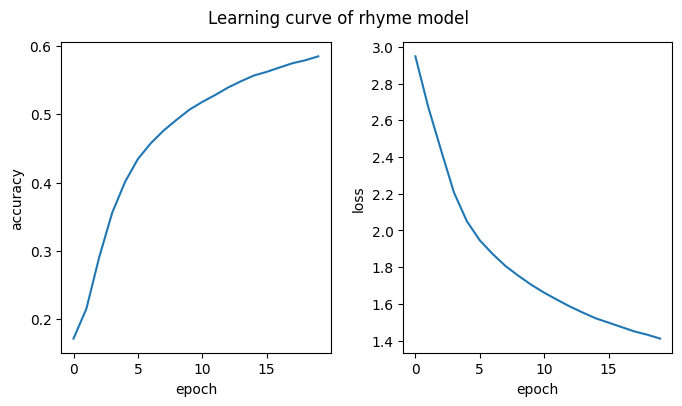

In [12]:
with open(f"data/models/{MODEL_NAME}/history.pickle", "rb") as f:
    history = pickle.load(f)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Learning curve of rhyme model")

ax1.plot(history['accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')

ax2.plot(history['loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
fig.tight_layout()
fig.set_size_inches(7, 4)
fig.savefig(f"data/models/{MODEL_NAME}/learning_curve.png")
plt.show()

In [76]:
for _ in range(4):
    print(generate_rhyme(MODEL, SEQUENCE_LENGTH, random.choice(list(RHYMES.keys()))))

snows bows
bested bested
appear shear
brain stain
